In [ ]:
#Don't use this block on the first run through. used to get back to directory with german data if rerunning entire notebook
%cd ../../../../

/content


In [ ]:
from google.colab import files
uploaded= files.upload()

Saving german.data to german.data


In [ ]:
import pandas as pd
import numpy as np

import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats  import entropy
from scipy.linalg import svd
from sklearn.decomposition import PCA, NMF
import sklearn
import numpy as np
from collections import namedtuple
import pandas as pd
from collections import Counter
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.stats import wasserstein_distance

In [ ]:
!pip install prettyprinter shap

     |████████████████████████████████| 51kB 3.3MB/s 
     |████████████████████████████████| 327kB 11.0MB/s 
     |████████████████████████████████| 204kB 18.6MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456461 sha256=1c65640640ad4232567fe6db0ecc7b9854f9966ade3c005254d2ca1c2a76f4bb
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


In [ ]:
file_name = "./german.data"

#read file
data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)
orig_data = pd.read_csv(
  file_name,
  sep = ' ',
  header=None
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/My\ Drive/EE464/alibi

/content/drive/My Drive/EE464/alibi


In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


Make the column names more descriptive

In [ ]:
data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

In [ ]:
# translate from codes to descriptive things
data.replace({"checking_acct": {'A11' : 'lt_0',
 'A12' : '0_to_200',
 'A13' : 'geq_200',
 'A14' : 'no acct'}}, inplace=True)

data.replace({"credit_hist": {'A30' : 'no_cred_all_paid',
 'A31' : 'all_credit_bank_paid',
 'A32' : 'existing_credits_paid',
 'A33' : 'delay_in_past',
 'A34' : 'critical_accts_other_bank_credits'}}, inplace=True)

data.replace({"purpose": {
 'A40' : 'car_new',
 'A41' : 'car_used',
 'A42' : 'furniture_equipment',
 'A43' : 'radio_tv',
 'A44' : 'home_appliances',
 'A45' : 'repairs',
 'A46' : 'education',
 'A47' : 'vacation',
 'A48' : 'retraining',
 'A49' : 'business',
 'A410' : 'other'}}, inplace=True)

data.replace({"savings": {
 'A61' : 'lt_100',
 'A62' : 'lt_500',
 'A63' : '100_to_500',
 'A64' : '500_to_1000',
 'A65' : 'unknown_or_no_account'}}, inplace=True)

data.replace({"employ_years": {
 'A71' : 'unemployed',
 'A72' : 'lt_1',
 'A73' : '1_to_4',
 'A74' : '4_to_7',
 'A75' : 'geq_7'}}, inplace=True)

data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

data.replace({"other_debtors": {
 'A101' : 'none',
 'A102' : 'co_applicant',
 'A103' : 'guarantor'}}, inplace=True)

data.replace({"property": {
 'A121' : 'real_estate',
 'A122' : 'building_soc_saving_life_insurance',
 'A123' : 'car_other',
 'A124' : 'unknown_none'}}, inplace=True)

data.replace({"other_installments": {
 'A141' : 'bank',
 'A142' : 'stores',
 'A143' : 'none'}}, inplace=True)

data.replace({"housing": {
 'A151' : 'rent',
 'A152' : 'own',
 'A153' : 'free'}}, inplace=True)

data.replace({"job": {
 'A171' : 'unemploy_unskilled_non_res',
 'A172' : 'unskill_resident',
 'A173' : 'skilled_official',
 'A174' : 'management_self_highQualified_officer'}}, inplace=True)

data.replace({"telephone": {
 'A191' : 'none',
 'A192' : 'yes'}}, inplace=True)

data.replace({"foreign": {
 'A201' : 'yes',
 'A202' : 'no'}}, inplace=True)

#1 means good credit, 2 means bad credit
data.replace({"ground_truth": {
 1 : 1,
 2 : 0}}, inplace=True)


data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,resident_since,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,lt_0,6,critical_accts_other_bank_credits,radio_tv,1169,unknown_or_no_account,geq_7,4,male_single,none,4,real_estate,67,none,own,2,skilled_official,1,yes,yes,1
1,0_to_200,48,existing_credits_paid,radio_tv,5951,lt_100,1_to_4,2,female_div_sep_married,none,2,real_estate,22,none,own,1,skilled_official,1,none,yes,0
2,no acct,12,critical_accts_other_bank_credits,education,2096,lt_100,4_to_7,2,male_single,none,3,real_estate,49,none,own,1,unskill_resident,2,none,yes,1
3,lt_0,42,existing_credits_paid,furniture_equipment,7882,lt_100,4_to_7,2,male_single,guarantor,4,building_soc_saving_life_insurance,45,none,free,1,skilled_official,2,none,yes,1
4,lt_0,24,delay_in_past,car_new,4870,lt_100,1_to_4,3,male_single,none,4,unknown_none,53,none,free,2,skilled_official,2,none,yes,0


In [ ]:
data['sex'] = (data['married_and_sex'] == 'female_div_sep_married').astype('int')
data['sex'] = data['sex'].map({1 : 'female', 0 : 'male'})

In [ ]:
data = data.drop(columns=['married_and_sex'])

Find categorical columns

In [ ]:
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))

#Apply Feature Map Approach (FMA)

Remapping function definition (h(.) in paper)

In [ ]:
def getCategoryReMapBounds(freqMapDict):
  sorted_dict = sorted(freqMapDict.items(), key=lambda x: x[1]) #sort the frequency map dictionary based on frequency of categories
  boundsList = []
  ub = 0.0
  #Form a list of the bounds for each category
  for i in range(len(sorted_dict)):
    if i < (len(sorted_dict)-1):
      lb = ub
      ub = (sorted_dict[i][1]+sorted_dict[i+1][1])/2
      boundsList.append((lb, ub))
  boundsList.append((ub,1.0))
  categories, _ = zip(*sorted_dict)
  res = [(boundsList[i], categories[i] ) for i in range(len(boundsList))] #map the bounds back onto the categories
  return res

def isInBounds(x, lb, ub):
  return (x >= lb and x <= ub)

In [ ]:
featureToBoundsDict = {}
for feature in cat_cols:
  mydict = data[feature].value_counts().to_dict() #gets feature_map for a categorical column as a dict
  maximum = mydict[max(mydict, key=mydict.get)] #get the maximum value in that dict, i.e. the freqeuncy of the highest frequency category of that feature
  newDict = {k:(maximum-v)/(maximum-1) for k, v in mydict.items()} #map the frequency counts onto real values in the range [0,1]
  featureToBoundsDict[feature] = getCategoryReMapBounds(newDict) #get the bounds for each category for remapping real number to category after the prediction
  data[feature] = data[feature].replace(newDict) #replace the categorical variables with the real values

In [ ]:
data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,other_debtors,resident_since,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth,sex
0,0.305344,6,0.448015,0.000000,1169,0.697674,0.254438,4,0.000000,4,0.151057,67,0.0,0.000000,2,0.000000,1,0.322689,0.0,1,0.000000
1,0.318066,48,0.000000,0.000000,5951,0.000000,0.000000,2,0.000000,2,0.151057,22,0.0,0.000000,1,0.000000,1,0.000000,0.0,0,0.551524
2,0.000000,12,0.448015,0.824373,2096,0.000000,0.488166,2,0.000000,3,0.151057,49,0.0,0.000000,1,0.683625,2,0.000000,0.0,1,0.000000
3,0.305344,42,0.000000,0.354839,7882,0.000000,0.488166,2,0.943709,4,0.302115,45,0.0,0.849719,1,0.000000,2,0.000000,0.0,1,0.000000
4,0.305344,24,0.835539,0.164875,4870,0.000000,0.000000,3,0.000000,4,0.537764,53,0.0,0.849719,2,0.000000,2,0.000000,0.0,0,0.000000


In [ ]:
featureToBoundsDict

{'checking_acct': [((0.0, 0.15267175572519084), 'no acct'),
  ((0.15267175572519084, 0.31170483460559795), 'lt_0'),
  ((0.31170483460559795, 0.5801526717557253), '0_to_200'),
  ((0.5801526717557253, 1.0), 'geq_200')],
 'credit_hist': [((0.0, 0.22400756143667297), 'existing_credits_paid'),
  ((0.22400756143667297, 0.6417769376181475),
   'critical_accts_other_bank_credits'),
  ((0.6417769376181475, 0.8724007561436673), 'delay_in_past'),
  ((0.8724007561436673, 0.9177693761814745), 'all_credit_bank_paid'),
  ((0.9177693761814745, 1.0), 'no_cred_all_paid')],
 'employ_years': [((0.0, 0.12721893491124261), '1_to_4'),
  ((0.12721893491124261, 0.371301775147929), 'geq_7'),
  ((0.371301775147929, 0.4911242603550296), '4_to_7'),
  ((0.4911242603550296, 0.6568047337278107), 'lt_1'),
  ((0.6568047337278107, 1.0), 'unemployed')],
 'foreign': [((0.0, 0.4812889812889813), 'yes'),
  ((0.4812889812889813, 1.0), 'no')],
 'housing': [((0.0, 0.375), 'own'),
  ((0.375, 0.7998595505617978), 'rent'),
  ((0.

In [ ]:
X =  data.drop(columns=['ground_truth',])
y =  data.loc[:, 'ground_truth']
# X =  data.drop(columns=[20,])
# y =  data.loc[:, 20]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2, random_state = 4)

#XGBoost

In [ ]:
xgb_full = xgboost.DMatrix(X, label=y)
xgb_train =  xgboost.DMatrix(X_train, label = y_train)
xgb_test = xgboost.DMatrix(X_test, label = y_test)

params = {
"eta": 0.002,
"max_depth": 4,
"objective": 'binary:logistic',
"eval_metric":"auc",
"subsample": 0.5
}
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_train, nfold = 3, metrics="auc" , num_boost_round=10)

[0]	test-auc:0.720459
[1000]	test-auc:0.780983
[2000]	test-auc:0.794446
[3000]	test-auc:0.805145
[4000]	test-auc:0.809352
[5000]	test-auc:0.811396
[6000]	test-auc:0.815362
[7000]	test-auc:0.814281
[8000]	test-auc:0.816685
[9000]	test-auc:0.815603
[9999]	test-auc:0.814882


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.780720,0.007344,0.690198,0.025842
1,0.808879,0.010861,0.703480,0.014679
2,0.822999,0.000923,0.723031,0.021161
3,0.833097,0.005775,0.732618,0.031637
4,0.836907,0.006109,0.739009,0.030141
5,0.845618,0.008213,0.747036,0.027000
6,0.851456,0.007604,0.748451,0.025244
7,0.854207,0.009882,0.751436,0.032153
8,0.857203,0.011260,0.755752,0.028250
9,0.857272,0.011861,0.761727,0.027857


In [ ]:
y_pred = model.predict(xgb_test)

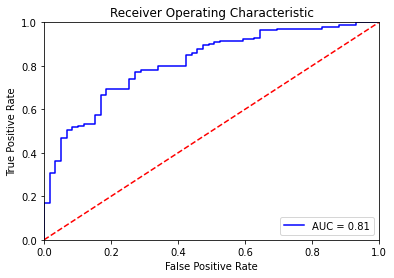

Optimal Threshold obtained using difference of TPR and FPR 0.7876959


In [ ]:
fpr, tpr , thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
#data_final['y_pred'] = np.where(data_final['pred'] > optimal_threshold, 1, 0)

#Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.770885923788917

#MACEM

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


In [ ]:
class_names=["bad credit","good credit"]

In [ ]:
idx = 195
X0 = X_test.iloc[idx,:].values.reshape(1,-1)#.reshape((1,) + X_test[idx].shape)
print('Prediction on instance to be explained: {}'.format(class_names[np.argmax(clf.predict_proba(X0))]))
print('Prediction probabilities for each class on the instance: {}'.format(clf.predict_proba(X0)))

Prediction on instance to be explained: good credit
Prediction probabilities for each class on the instance: [[0.43090165 0.56909835]]


CEM parameters:

In [ ]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + X_train.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes 
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or 
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (X_train.min(axis=0).values.reshape(shape)-100,  # feature range for the perturbed instance
                 X_train.max(axis=0).values.reshape(shape)+100)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

In [ ]:
eps0 = np.array([[1e-2, 1e-2]])  # 2 prediction categories, equivalent to 1e-2
eps1 = np.array([[1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]])  # 20 features, also equivalent to 1e-2
eps = (eps0, eps1)

In [ ]:
update_num_grad = 1 

Generate pertinent negative:

In [ ]:
# define model
#lr = load_model('iris_lr.h5')

predict_fn = lambda x: clf.predict_proba(x)  # only pass the predict fn which takes numpy arrays to CEM
                                      # explainer can no longer minimize wrt model weights

# initialize CEM explainer and explain instance
cemPN = CEM(predict_fn, mode, shape, kappa=kappa, beta=beta, 
          feature_range=feature_range, max_iterations=max_iterations, 
          eps=eps, c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init, 
          clip=clip, update_num_grad=update_num_grad)
cemPN.fit(X_train.values, no_info_type='median')
explanationPN = cemPN.explain(X0, verbose=False)

No PN found!


In [ ]:
print('Original instance: {}'.format(explanationPN.X))
print('Predicted class: {}'.format(class_names[explanationPN.X_pred]))

Original instance: [[3.18066158e-01 1.20000000e+01 0.00000000e+00 9.24731183e-01
  6.39000000e+02 0.00000000e+00 0.00000000e+00 4.00000000e+00
  0.00000000e+00 2.00000000e+00 0.00000000e+00 3.00000000e+01
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Predicted class: good credit


In [ ]:
print('Pertinent negative: {}'.format(explanationPN.PN))
print('Predicted class: {}'.format(class_names[explanationPN.PN_pred]))

Pertinent negative: None


TypeError: ignored

In [ ]:
expl = {}
expl['PN'] = explanationPN.PN
expl['PN_pred'] = explanationPN.PN_pred

In [ ]:
#Returns the category that the frequency mapped prediction of the category (a real number) should be remapped onto
def reMap(featureToBoundsDict, feature, x):
  bounds = featureToBoundsDict[feature]
  for bound in bounds:
    if isInBounds(x, *bound[0]):
      return bound[1]

In [ ]:
def remappedExplanation(explanation, mode):
  remappedExplanation = []
  feature_names = data.columns.drop(['ground_truth'])
  if mode == "PN":
    for i in range(len(feature_names)):
      remappedExplanation.append(explanation.PN[0][i]) 
      if feature_names[i] in cat_cols:
        remappedExplanation[i] = reMap(featureToBoundsDict, feature_names[i], explanation.PN[0][i]) 
  elif mode == "PP":
    for i in range(len(feature_names)):
      remappedExplanation.append(explanation.PP[0][i]) 
      if feature_names[i] in cat_cols:
        remappedExplanation[i] = reMap(featureToBoundsDict, feature_names[i], explanation.PP[0][i]) 
  else:
    for i in range(len(feature_names)):
      remappedExplanation.append(explanation.X[0][i]) 
      if feature_names[i] in cat_cols:
        remappedExplanation[i] = reMap(featureToBoundsDict, feature_names[i], explanation.X[0][i]) 
  return remappedExplanation

In [ ]:
remappedExplanation(explanationPN, "PN")

In [ ]:
remappedExplanation(explanationPN, "orig")

In [ ]:
X_orig =  orig_data.drop(columns=[20,])
y_orig =  orig_data.iloc[:, 20]
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size =  0.2, random_state = 4)

In [ ]:
X_test_orig.iloc[idx,:].values.reshape(1,-1)#

array([['A11', 15, 'A30', 'A40', 950, 'A61', 'A75', 4, 'A93', 'A101', 3,
        'A123', 33, 'A143', 'A151', 2, 'A173', 2, 'A191', 'A201']],
      dtype=object)

In [ ]:
mode = "PP"

predict_fn = lambda x: clf.predict_proba(x)  # only pass the predict fn which takes numpy arrays to CEM
                                      # explainer can no longer minimize wrt model weights

# initialize CEM explainer and explain instance
cemPP = CEM(predict_fn, mode, shape, kappa=kappa, beta=beta, 
          feature_range=feature_range, max_iterations=max_iterations, 
          eps=eps, c_init=c_init, c_steps=c_steps, learning_rate_init=lr_init, 
          clip=clip, update_num_grad=update_num_grad)
cemPP.fit(X_train.values, no_info_type='median')
explanation = cemPP.explain(X0, verbose=False)

In [ ]:
print('Pertinent positive: {}'.format(explanation.PP))
print('Predicted class: {}'.format(class_names[explanation.PP_pred]))

Pertinent positive: [[ 7.81078680e-09  0.00000000e+00  0.00000000e+00 -1.21772931e-08
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Predicted class: good credit


In [ ]:
remappedExplanation(explanation, "PP")

['no acct',
 0.0,
 'existing_credits_paid',
 None,
 0.0,
 'lt_100',
 '1_to_4',
 0.0,
 'none',
 0.0,
 'car_other',
 0.0,
 'none',
 'own',
 0.0,
 'skilled_official',
 0.0,
 'none',
 'yes',
 'male']

In [ ]:
remappedExplanation(explanation, "orig")

['0_to_200',
 12.0,
 'existing_credits_paid',
 'repairs',
 639.0,
 'lt_100',
 '1_to_4',
 4.0,
 'none',
 2.0,
 'car_other',
 30.0,
 'none',
 'own',
 1.0,
 'skilled_official',
 1.0,
 'none',
 'yes',
 'male']

In [ ]:
for idx in range(len(X_test))
  X0 = X_test.iloc[idx,:].values.reshape(1,-1)
  print("{}: ".format(idx), end ='')
  explanation = cem.explain(X0, verbose=False)

No PN found!


#Visualization

In [ ]:
df = data
df['decision'] = np.array([class_names[i] for i in y])

In [ ]:
expl['PN'].shape

(1, 20)

In [ ]:
feature_names = data.columns.drop(['ground_truth','decision'])

In [ ]:
pn = pd.DataFrame(expl['PN'], columns=feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
#pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
#pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=feature_names)
orig_inst['species'] = 'orig_' + class_names[explanationPN.X_pred]
#df = df.append([pn, pp, orig_inst], ignore_index=True)
df = df.append([pn, orig_inst], ignore_index=True)

In [ ]:
#np.argmax(y_pred, axis=1)

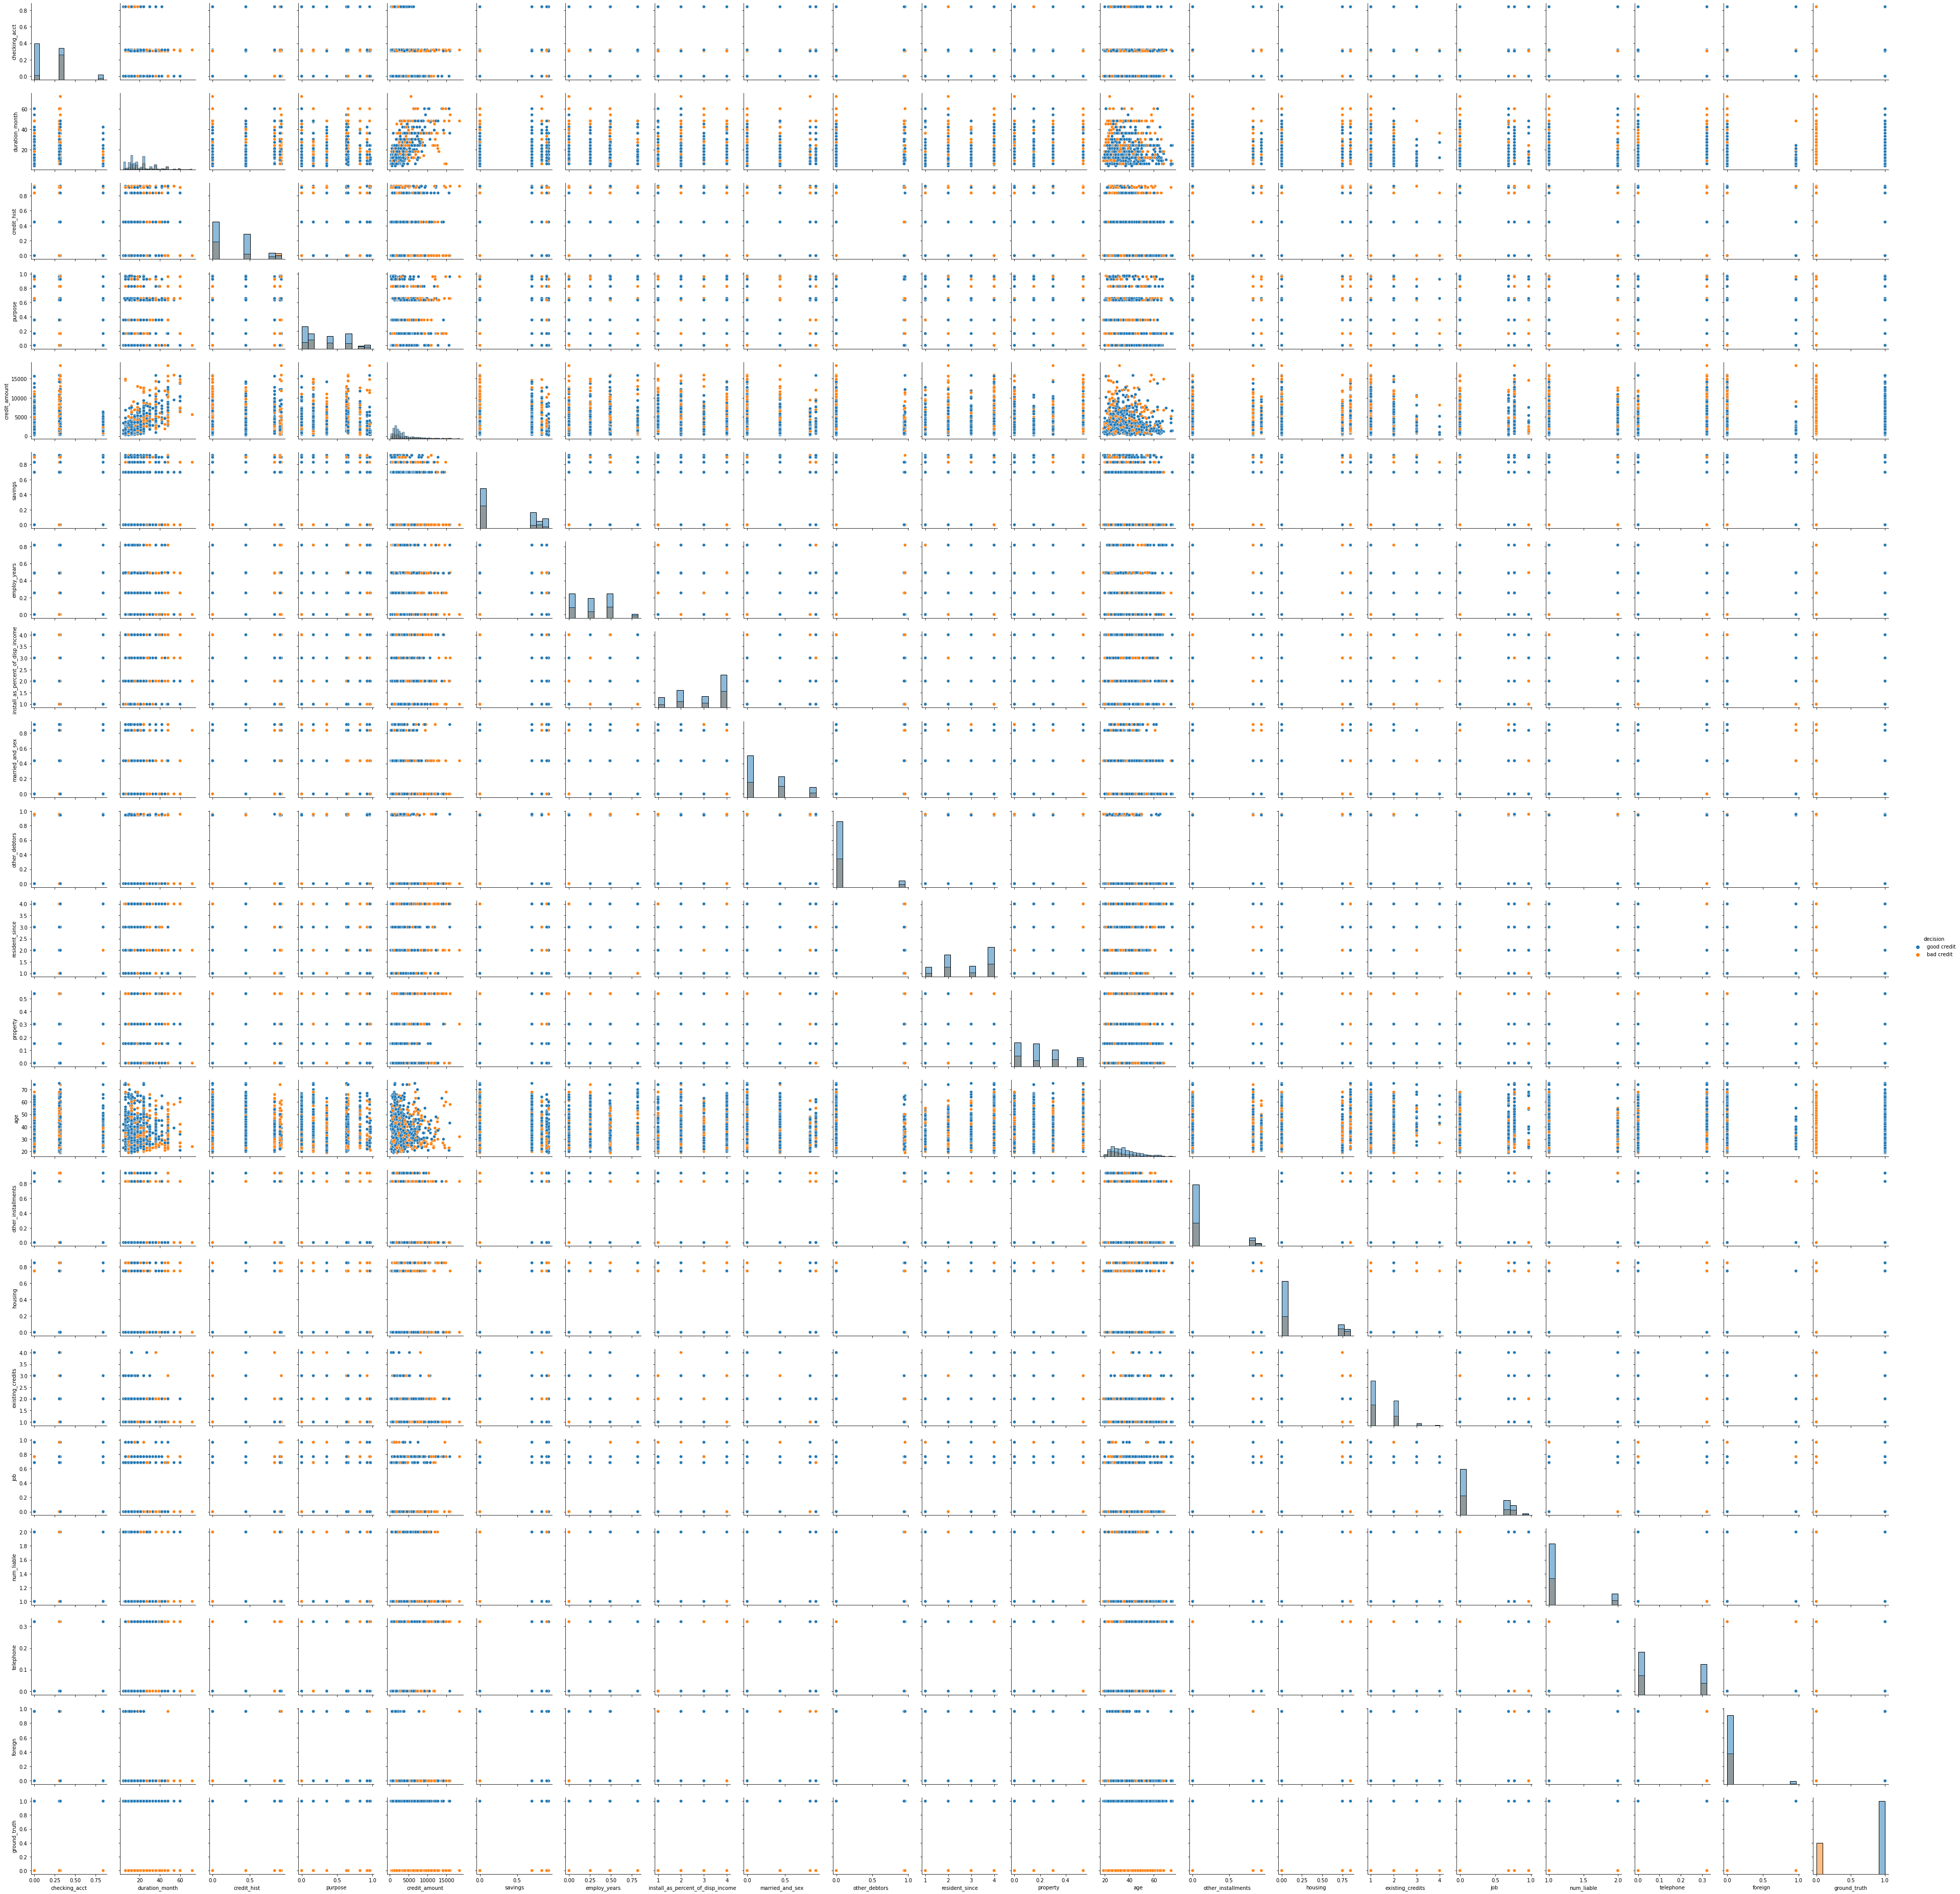

In [ ]:
fig = sns.pairplot(df, hue='decision', diag_kind='hist');

#Miscellaneous stuff

In [ ]:
data.columns = ['checking_acct', 'duration_month', 'credit_hist',
                    'purpose', 'credit_amount', 'savings', 'employ_years',
                    'install_as_percent_of_disp_income', 'married_and_sex',
                    'other_debtors', 'resident_since', 'property',
                    'age', 'other_installments', 'housing', 'existing_credits',
                    'job', 'num_liable', 'telephone', 'foreign', 'ground_truth']

# translate from codes to descriptive things
data.replace({"checking_acct": {'A11' : 'lt_0',
 'A12' : '0_to_200',
 'A13' : 'geq_200',
 'A14' : 'no acct'}}, inplace=True)

data.replace({"credit_hist": {'A30' : 'no_cred_all_paid',
 'A31' : 'all_credit_bank_paid',
 'A32' : 'existing_credits_paid',
 'A33' : 'delay_in_past',
 'A34' : 'critical_accts_other_bank_credits'}}, inplace=True)

data.replace({"purpose": {
 'A40' : 'car_new',
 'A41' : 'car_used',
 'A42' : 'furniture_equipment',
 'A43' : 'radio_tv',
 'A44' : 'home_appliances',
 'A45' : 'repairs',
 'A46' : 'education',
 'A47' : 'vacation',
 'A48' : 'retraining',
 'A49' : 'business',
 'A410' : 'other'}}, inplace=True)

data.replace({"savings": {
 'A61' : 'lt_100',
 'A62' : 'lt_500',
 'A63' : '100_to_500',
 'A64' : '500_to_1000',
 'A65' : 'unknown_or_no_account'}}, inplace=True)

data.replace({"employ_years": {
 'A71' : 'unemployed',
 'A72' : 'lt_1',
 'A73' : '1_to_4',
 'A74' : '4_to_7',
 'A75' : 'geq_7'}}, inplace=True)

data.replace({"married_and_sex": {
 'A91' : 'male_div_sep',
 'A92' : 'female_div_sep_married',
 'A93' : 'male_single',
 'A94' : 'male_married_widowed',
 'A95' : 'female_single'}}, inplace=True)

data.replace({"other_debtors": {
 'A101' : 'none',
 'A102' : 'co_applicant',
 'A103' : 'guarantor'}}, inplace=True)

data.replace({"property": {
 'A121' : 'real_estate',
 'A122' : 'building_soc_saving_life_insurance',
 'A123' : 'car_other',
 'A124' : 'unknown_none'}}, inplace=True)

data.replace({"other_installments": {
 'A141' : 'bank',
 'A142' : 'stores',
 'A143' : 'none'}}, inplace=True)

data.replace({"housing": {
 'A151' : 'rent',
 'A152' : 'own',
 'A153' : 'free'}}, inplace=True)

data.replace({"job": {
 'A171' : 'unemploy_unskilled_non_res',
 'A172' : 'unskill_resident',
 'A173' : 'skilled_official',
 'A174' : 'management_self_highQualified_officer'}}, inplace=True)

data.replace({"telephone": {
 'A191' : 'none',
 'A192' : 'yes'}}, inplace=True)

data.replace({"foreign": {
 'A201' : 'yes',
 'A202' : 'no'}}, inplace=True)

#1 means good credit, 2 means bad credit
data.replace({"ground_truth": {
 1 : 1,
 2 : 0}}, inplace=True)


data.head()

,checking_acct,duration_month,credit_hist,purpose,credit_amount,savings,employ_years,install_as_percent_of_disp_income,married_and_sex,other_debtors,resident_since,property,age,other_installments,housing,existing_credits,job,num_liable,telephone,foreign,ground_truth
0,lt_0,6,critical_accts_other_bank_credits,radio_tv,1169,unknown_or_no_account,geq_7,4,male_single,none,4,real_estate,67,none,own,2,skilled_official,1,yes,yes,1
1,0_to_200,48,existing_credits_paid,radio_tv,5951,lt_100,1_to_4,2,female_div_sep_married,none,2,real_estate,22,none,own,1,skilled_official,1,none,yes,0
2,no acct,12,critical_accts_other_bank_credits,education,2096,lt_100,4_to_7,2,male_single,none,3,real_estate,49,none,own,1,unskill_resident,2,none,yes,1
3,lt_0,42,existing_credits_paid,furniture_equipment,7882,lt_100,4_to_7,2,male_single,guarantor,4,building_soc_saving_life_insurance,45,none,A153,1,skilled_official,2,none,yes,1
4,lt_0,24,delay_in_past,car_new,4870,lt_100,1_to_4,3,male_single,none,4,unknown_none,53,none,A153,2,skilled_official,2,none,yes,0


###Determine base values

In [ ]:
X.columns

Index(['duration_month', 'credit_amount', 'install_as_percent_of_disp_income',
       'resident_since', 'age', 'existing_credits', 'num_liable',
       'checking_acct_0_to_200', 'checking_acct_geq_200', 'checking_acct_lt_0',
       'checking_acct_no acct', 'credit_hist_all_credit_bank_paid',
       'credit_hist_critical_accts_other_bank_credits',
       'credit_hist_delay_in_past', 'credit_hist_existing_credits_paid',
       'credit_hist_no_cred_all_paid', 'purpose_business', 'purpose_car_new',
       'purpose_car_used', 'purpose_education', 'purpose_furniture_equipment',
       'purpose_home_appliances', 'purpose_other', 'purpose_radio_tv',
       'purpose_repairs', 'purpose_retraining', 'savings_100_to_500',
       'savings_500_to_1000', 'savings_lt_100', 'savings_lt_500',
       'savings_unknown_or_no_account', 'employ_years_1_to_4',
       'employ_years_4_to_7', 'employ_years_geq_7', 'employ_years_lt_1',
       'employ_years_unemployed', 'other_debtors_co_applicant',
       'other_

In [ ]:
cat_columns = ['checking_acct','credit_hist', 'purpose', 'savings','employ_years','married_and_sex','other_debtors','property', 'other_installments', 'housing','job','telephone','foreign']

In [ ]:
ohe_columns = [
       'checking_acct_0_to_200', 'checking_acct_geq_200', 'checking_acct_lt_0',
       'checking_acct_no acct', 'credit_hist_all_credit_bank_paid',
       'credit_hist_critical_accts_other_bank_credits',
       'credit_hist_delay_in_past', 'credit_hist_existing_credits_paid',
       'credit_hist_no_cred_all_paid', 'purpose_business', 'purpose_car_new',
       'purpose_car_used', 'purpose_education', 'purpose_furniture_equipment',
       'purpose_home_appliances', 'purpose_other', 'purpose_radio_tv',
       'purpose_repairs', 'purpose_retraining', 'savings_100_to_500',
       'savings_500_to_1000', 'savings_lt_100', 'savings_lt_500',
       'savings_unknown_or_no_account', 'employ_years_1_to_4',
       'employ_years_4_to_7', 'employ_years_geq_7', 'employ_years_lt_1',
       'employ_years_unemployed', 'other_debtors_co_applicant',
       'other_debtors_guarantor', 'other_debtors_none',
       'property_building_soc_saving_life_insurance', 'property_car_other',
       'property_real_estate', 'property_unknown_none',
       'other_installments_bank', 'other_installments_none',
       'other_installments_stores', 'housing_A153', 'housing_own',
       'housing_rent', 'job_management_self_highQualified_officer',
       'job_skilled_official', 'job_unemploy_unskilled_non_res',
       'job_unskill_resident', 'telephone_none', 'telephone_yes', 'foreign_no',
       'foreign_yes'],

Find mode of categorical variables

In [ ]:
for feature in ohe_columns[0]:
  print(feature + ":" + str(X[feature].mode()))

checking_acct_0_to_200:0    0
dtype: uint8
checking_acct_geq_200:0    0
dtype: uint8
checking_acct_lt_0:0    0
dtype: uint8
checking_acct_no acct:0    0
dtype: uint8
credit_hist_all_credit_bank_paid:0    0
dtype: uint8
credit_hist_critical_accts_other_bank_credits:0    0
dtype: uint8
credit_hist_delay_in_past:0    0
dtype: uint8
credit_hist_existing_credits_paid:0    1
dtype: uint8
credit_hist_no_cred_all_paid:0    0
dtype: uint8
purpose_business:0    0
dtype: uint8
purpose_car_new:0    0
dtype: uint8
purpose_car_used:0    0
dtype: uint8
purpose_education:0    0
dtype: uint8
purpose_furniture_equipment:0    0
dtype: uint8
purpose_home_appliances:0    0
dtype: uint8
purpose_other:0    0
dtype: uint8
purpose_radio_tv:0    0
dtype: uint8
purpose_repairs:0    0
dtype: uint8
purpose_retraining:0    0
dtype: uint8
savings_100_to_500:0    0
dtype: uint8
savings_500_to_1000:0    0
dtype: uint8
savings_lt_100:0    1
dtype: uint8
savings_lt_500:0    0
dtype: uint8
savings_unknown_or_no_account:0

Find median of continuous variables

In [ ]:
for feature in X.columns: 
  if feature not in ohe_columns[0]:
    print(feature + ":" + str(X[feature].median()))

duration_month:18.0
credit_amount:2319.5
install_as_percent_of_disp_income:3.0
resident_since:3.0
age:33.0
existing_credits:1.0
num_liable:1.0
